# 0) Import Dependencies

In [1]:
    #Gathering data
import pandas as pd
import numpy as np
    #Models
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
    #Evaluating results
import matplotlib.pyplot as plt
%matplotlib inline
    #Python built-ins
from collections import OrderedDict
import operator
import sys

In [2]:
#Set seed (for controlling reproducability)
np.random.seed(1)

# 1) Get Data

## -Load

In [3]:
#Read in data
cols = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 
        'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type', 
        'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-rate', 'horsepower', 
        'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
cars = pd.read_csv('imports-85.data', names=cols)

We load in the data, making sure to label each column properly so we know which data belongs to which features.

## -Remove Inapplicable Data

In [4]:
#Select columns to remove
drop_columns = ['make', 'fuel-type', 'aspiration', 'body-style', 
                'drive-wheels', 'engine-location', 'engine-type', 'fuel-system',
               'num-of-doors', 'num-of-cylinders', 'symboling', 'engine-size',
               'normalized-losses']
cars = cars.drop(drop_columns, axis=1)

Here, we choose which features we are going to train the model on.

I chose to remove any feature that was:
1. Non-numerical *(make, fuel-type, aspiration, body-style, drive-wheels, engine-location, engine-type, fuel-system)*
2. Non-ordinal *(num-of-doors, num-of-cylinders, symboling, engine-size)*
3. Had too many NaN's *(normalized-losses)*

## -Clean

In [5]:
#Replace all ?'s with NaN's
numeric_cars = cars.replace(to_replace='?', value=np.nan)
#Drop all rows with NaN's
numeric_cars = numeric_cars.dropna(axis=0)
#Convert all to float64
numeric_cars = numeric_cars.astype(dtype='float64')
#Normalize all values so all values range from 0 to 1, except target feature
normalized_cars = (numeric_cars - numeric_cars.min())/(numeric_cars.max() - numeric_cars.min())
normalized_cars['price'] = numeric_cars['price']

We remove all remaining messy data, and convert the data to a format that the model can accurately train on.

# 2) Train model

## -Build (best) model

In [6]:
#Construct a multivariate variable k model
def create_model(feature_labels, df):
    # SHAPE DATA
    # Randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)
    
    #partition data
    df_length = rand_df.index.size
    partition_start = int(df_length*.75)
    train_df = df.iloc[0:partition_start]
    test_df = df.iloc[partition_start:]
    
    # TRAIN MODEL
    #init
    knn = KNeighborsRegressor(n_neighbors=12)
    
    #fit
    train_feature = df[feature_labels]
    train_target = df['price']
    knn.fit(train_feature, train_target)
    
    return knn

In [7]:
best_model_features = ['wheel-base', 'width', 'length', 'curb-weight', 'horsepower'] #See "Show Your Work" section to determine best features
best_model = create_model(best_model_features, normalized_cars)

# 3) Create end-to-end solution

## -Take in user's data

In [8]:
#A function to create a dictionary from two lists (that represent keys and values)
def create_dict(keys, values):
    return dict(zip(keys, values + [None] * (len(keys) - len(values))))

In [9]:
#Take in and store the user's data for their car listing, but only the features necessary to predict a price
user_listing = list()
for i in range(len(cols)):
    curr_feature = cols[i]
    if curr_feature in best_model_features:
        user_input = input(curr_feature + ": ")
        try:
            user_input = float(user_input)
        except ValueError:    #ensure the user will input numbers
            print("ERROR: Invalid input for this feature: " + "'" + curr_feature + "'")
            sys.exit()
        else:
            user_listing.append([float(user_input)])  #store user-input as a float
    else:
        user_listing.append(['?'])

wheel-base: 6
length: 7
width: 8
curb-weight: 9
horsepower: 1


In [10]:
#Convert the user's car listing to a format the model can process
user_data = create_dict(cols, user_listing)
user_df = pd.DataFrame(data=user_data)
user_df

,aspiration,body-style,bore,city-mpg,compression-rate,curb-weight,drive-wheels,engine-location,engine-size,engine-type,...,make,normalized-losses,num-of-cylinders,num-of-doors,peak-rpm,price,stroke,symboling,wheel-base,width
0,?,?,?,?,?,9.0,?,?,?,?,...,?,?,?,?,?,?,?,?,6.0,8.0


## -Predict price

In [11]:
#A function to predict a price using premade sklearn KNN model
def predict_price(knn_model, user_data, feature_labels):
    #predict
    prediction = knn_model.predict(user_data[feature_labels])
    predicted_value = prediction[0]
    predicted_price = "$" + "%.2f" % round(predicted_value,2)   #round to two decimal places and display as a dollar amount
    
    return predicted_price

In [12]:
prediction = predict_price(best_model, user_df, best_model_features)
print("Your car is worth: " + prediction + ".")

Your car is worth: $31463.25.


# 3) Show Your Work

### Reasoning Behind the Settings on Our Price Predictor Model

**Ultimate Goal**: To find the best performing model to put into our price predictor


* In order to do that with the tools available, we need to find:

    A. The __*best feature selection*__
    
    B. __*Optimal hyperparameter values*__ (in this case, best k-value for number of neighbors to include in predicting our price)
    
    
* A. To achieve the __best feature selection__, we need to:

    i. Rank how each feature individually performs in its ability to accurately predict a price (*univariate models*)
    
    ii. Compare how different combinations of the best ranking features perform (*multivariate models*)
    
    
* B. To find the __optimal k-value__ to reduce error further, we test the best multivariate models across multiple k-values to find the k-value that performs the best for each model


**Conclusion**: The model that has the lowest error value for its specific combination of feature selection and optimal hyperparameters is the best model, and the model we will use in our script to predict car prices.

# Univariate Model (Find the Best Features)

Our first order of business is to **rank how each feature individually performs in its ability to accurately predict a price.**

### The Original Function (static k)

In [13]:
def knn_train_test(train_name, target_name, df):
    np.random.seed(1)
        
    # Randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)
    
    #partition data
    df_length = rand_df.index.size
    partition_start = int(df_length*.75)
    train_df = rand_df.iloc[0:partition_start]
    test_df = rand_df.iloc[partition_start:]
    
    # TRAIN MODEL
    #init
    knn = KNeighborsRegressor()
    
    #fit
    train_feature = df[[train_name]]
    train_target = df[target_name]
    knn.fit(train_feature, train_target)
    
    #predict
    predictions = knn.predict(test_df[[train_name]])
    
    #eval
    mse = mean_squared_error(test_df[target_name], predictions)
    rmse = mse**(1/2)
    
    return rmse

In [14]:
#Test every feature as a univariate model to see which performs best
features_list = list(normalized_cars)
features_list.remove('price')

rmse_values = dict()
for feature in features_list:
    rmse = knn_train_test(feature, 'price', normalized_cars)
    rmse_values[feature] = rmse

In [15]:
#Print the name of the feature that resulted in lowest error
best_feature = min(rmse_values, key=rmse_values.get)

print("Best Feature: " +  best_feature)
print("Corresponding Error: " + str(rmse_values[best_feature]))

Best Feature: wheel-base
Corresponding Error: 2522.2496472921366


### Updated Function (Dynamic K)

In [16]:
def knn_train_test(train_name, target_name, df, k):
    np.random.seed(1)
        
    # Randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)
    
    #partition data
    df_length = rand_df.index.size
    partition_start = int(df_length*.75)
    train_df = rand_df.iloc[0:partition_start]
    test_df = rand_df.iloc[partition_start:]
    
    # TRAIN MODEL
    #init
    knn = KNeighborsRegressor(n_neighbors=k)
    
    #fit
    train_feature = df[[train_name]]
    train_target = df[target_name]
    knn.fit(train_feature, train_target)
    
    #predict
    predictions = knn.predict(test_df[[train_name]])
    
    #eval
    mse = mean_squared_error(test_df[target_name], predictions)
    rmse = mse**(1/2)
    
    return rmse

In [17]:
#Test each univariate model for a variety of k-values
features_list = list(normalized_cars)
features_list.remove('price')

rmse_values = dict()
for feature in features_list:
    k_values = [1,3,5,7,9]
    feature_rmses = OrderedDict()
    for k_val in k_values:
        rmse = knn_train_test(feature, 'price', normalized_cars, k_val)
        feature_rmses[k_val] = rmse
    rmse_values[feature] = feature_rmses

In [18]:
rmse_values

{'bore': OrderedDict([(1, 4056.9790308976035),
              (3, 3464.018563746061),
              (5, 3716.9482441642795),
              (7, 4056.6902903253726),
              (9, 4540.8415701586555)]),
 'city-mpg': OrderedDict([(1, 3120.04794900361),
              (3, 4225.225832765449),
              (5, 3427.8095727357404),
              (7, 2929.988948412191),
              (9, 3159.9371961158217)]),
 'compression-rate': OrderedDict([(1, 6137.808375394366),
              (3, 5558.805400916709),
              (5, 5378.105096687904),
              (7, 5476.186335178219),
              (9, 5728.390895658601)]),
 'curb-weight': OrderedDict([(1, 265.3527878896627),
              (3, 2967.809094027799),
              (5, 3675.7224743676484),
              (7, 3728.964908250514),
              (9, 3711.426593750194)]),
 'height': OrderedDict([(1, 8200.508401362462),
              (3, 6293.937093970446),
              (5, 5603.7282680409135),
              (7, 5398.515016751286),
        

We use an OrderedDict() on the nested dictionary for each feature so that when we retrieve the rmse values, they stay in order to their respective k-values and thus will not cause problems for plotting in matplotlib.

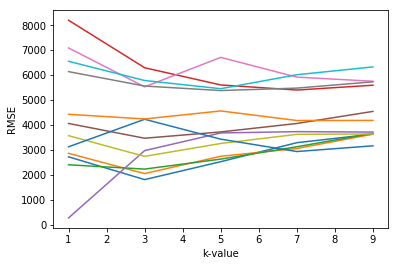

In [19]:
#Plot out results for each model, to display how each feature performed
for k,v in rmse_values.items():
    #Create a list of each k-value for the current feature
    x = list(v.keys())
    #Create a list of the corresponding rmses for each k-value
    y = list(v.values())
    #Plot one feature's graph
    plt.plot(x,y, label=k)
    
    #Label graph axes
    plt.xlabel('k-value')
    plt.ylabel('RMSE')

##### Which features performed the best?

In [20]:
#Get average rmse value for each feature
avg_rmses = dict()
for feature,val in rmse_values.items():
    current_feat_rmses = list(val.values())
    avg_rmse = np.mean(current_feat_rmses)
    avg_rmses[feature] = avg_rmse

#Display rmses in order of smallest to largest to see which feature did best (creates a list)
sorted_rmses = sorted(avg_rmses.items(), key=operator.itemgetter(1))
sorted_rmses

[('wheel-base', 2791.262319722563),
 ('width', 2806.419383426016),
 ('length', 2864.0645697954515),
 ('curb-weight', 2869.8551716571637),
 ('horsepower', 3362.736937769381),
 ('city-mpg', 3372.601899806563),
 ('bore', 3967.0955398583947),
 ('highway-mpg', 4315.658836443998),
 ('compression-rate', 5655.85922076716),
 ('peak-rpm', 6025.032572954997),
 ('stroke', 6198.749359786766),
 ('height', 6217.824784179195)]

# Multivariate Model (Find the Best Feature Selection)

Next on the list is to find the best **combination of the best ranking features** (aka: Feature Selection).

### Updated Function (Multivariate Static K)

In [21]:
def knn_train_test(feature_labels, target_name, df):
    np.random.seed(1)
        
    # Randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)
    
    #partition data
    df_length = rand_df.index.size
    partition_start = int(df_length*.75)
    train_df = rand_df.iloc[0:partition_start]
    test_df = rand_df.iloc[partition_start:]
    
    # TRAIN MODEL
    #init
    knn = KNeighborsRegressor()
    
    #fit
    train_feature = df[feature_labels]
    train_target = df[target_name]
    knn.fit(train_feature, train_target)
    
    #predict
    predictions = knn.predict(test_df[feature_labels])
    
    #eval
    mse = mean_squared_error(test_df[target_name], predictions)
    rmse = mse**(1/2)
    
    return rmse

In [22]:
#Get a list of all features, in order of best rmse values to worst
sorted_feat_labels = list()
for key,value in sorted_rmses:
    sorted_feat_labels.append(key)

#Retrieve labels for the features that ranked the best
two_best_feat = sorted_feat_labels[0:2]
three_best_feat = sorted_feat_labels[0:3]
four_best_feat = sorted_feat_labels[0:4]
five_best_feat = sorted_feat_labels[0:5]

multivar_labels = [two_best_feat, three_best_feat, 
                   four_best_feat, five_best_feat]
multivar_labels

[['wheel-base', 'width'],
 ['wheel-base', 'width', 'length'],
 ['wheel-base', 'width', 'length', 'curb-weight'],
 ['wheel-base', 'width', 'length', 'curb-weight', 'horsepower']]

In [23]:
mult_rmses = dict()
feat_labels = dict()

#Calculate rmse values for each model
for i in range(len(multivar_labels)):
    feature_count = i + 2
    key = str(feature_count) + "-features"
    feature_set = multivar_labels[i]
    mult_rmses[key] = knn_train_test(feature_set, 'price', normalized_cars)
    feat_labels[key] = feature_set
    

#Display rmses in order of smallest to largest to see which multivariate model did best
mult_rmses

{'2-features': 2752.650953061023,
 '3-features': 2751.1431577229337,
 '4-features': 2715.372762623946,
 '5-features': 1852.5634442852534}

In [24]:
#Get a list of the feature labels corresponding to the 3 best performing models, in order
best_models_labels = list()

for i in range(3):
    best_key = min(mult_rmses, key=mult_rmses.get)
    best_key_value = feat_labels[best_key]
    best_models_labels.append(best_key_value)
    mult_rmses.pop(best_key, None)

In [25]:
best_models_labels

[['wheel-base', 'width', 'length', 'curb-weight', 'horsepower'],
 ['wheel-base', 'width', 'length', 'curb-weight'],
 ['wheel-base', 'width', 'length']]

# Hyperparameter Tuning (Find the Optimal K-Value)

Finally, we test the best multivariate models across multiple k-values to find the **k-value that results in the least amount of error for each model.**

### Updated Fuction (Multivariate Variable K)

In [26]:
def knn_train_test(feature_labels, target_name, df, k):
    np.random.seed(1)
        
    # Randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)
    
    #partition data
    df_length = rand_df.index.size
    partition_start = int(df_length*.75)
    train_df = df.iloc[0:partition_start]
    test_df = df.iloc[partition_start:]
    
    # TRAIN MODEL
    #init
    knn = KNeighborsRegressor(n_neighbors=k)
    
    #fit
    train_feature = df[feature_labels]
    train_target = df[target_name]
    knn.fit(train_feature, train_target)
    
    #predict
    predictions = knn.predict(test_df[feature_labels])
    
    #eval
    mse = mean_squared_error(test_df[target_name], predictions)
    rmse = mse**(1/2)
    
    return rmse

In [27]:
best_model_rmses = dict()
k_values = [x for x in range(1,26)]

#Calculate rmses for varying k values for the 3 best models
for i in range(len(best_models_labels)):
    train_features = best_models_labels[i]
    current_model_vals = OrderedDict()
    
    #Calculate rmse values for each value of k
    for k in k_values:
        rmse = knn_train_test(train_features, 'price', normalized_cars, k)
        current_model_vals[k] = rmse
    
    #Dynamically label which model did best, 2nd best, 3rd best
    ranking = "[" + str(i+1) + "]"
    num_of_feat = str(len(best_models_labels[i]))
    key = ranking + " (" + num_of_feat + "-features)"
    best_model_rmses[key] = current_model_vals
    
best_model_rmses

{'[1] (5-features)': OrderedDict([(1, 130.94632020606844),
              (2, 905.0932948867645),
              (3, 1148.8932661311278),
              (4, 1209.1067752177848),
              (5, 1527.6146762792223),
              (6, 1538.3822439730084),
              (7, 1574.2662279936696),
              (8, 1686.1764336988062),
              (9, 1721.1986208354442),
              (10, 1736.4620821823733),
              (11, 1798.5137563160179),
              (12, 1777.508503819544),
              (13, 1809.7715049510628),
              (14, 1871.4241840577956),
              (15, 1943.9579284707786),
              (16, 1991.1297182971523),
              (17, 2029.286634362835),
              (18, 2038.7187697723837),
              (19, 2036.1620237421507),
              (20, 2046.9089452396363),
              (21, 2029.65183183496),
              (22, 2022.813406589919),
              (23, 2010.639945651565),
              (24, 1993.1863028570172),
              (25, 1973.801791153099

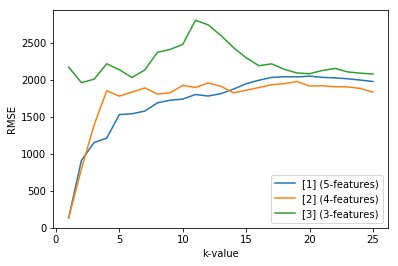

In [28]:
for k,v in best_model_rmses.items():
    #Create a list of each k-value for the current feature
    x = list(v.keys())
    #Create a list of the corresponding rmses for each k-value
    y = list(v.values())
    #Plot one feature's graph
    plt.plot(x,y, label=k)
    
    #Label graph axes
    plt.xlabel('k-value')
    plt.ylabel('RMSE')
    plt.legend(loc='lower right')

In conclusion, we can see the 5 features model performed the best both overall, even when each model is equipped with its respective optimal k value.

Side note: The optimal k-value can be found after the line stablizes out; it's the first trough before the rmse values begin to rise again.

Thus, our best model is a **model with the features ('wheel-base', 'width', 'length', 'curb-weight', 'horsepower') and with a k-value of 12.**  This is how I decided on the settings for the price predicting model to use in the script.  You may see it back in cell [5].